# XG Boost
Default parameters
max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:squarederror', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

In [1]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import ValidationCurve
import xgboost as xg

In [2]:
Data=pd.read_csv('1000_y_data.csv')
features = Data.columns[1:23]
target = Data.columns[23:50]
Chest_deflection = Data.columns[23]
pelvis = Data.columns[24]
Rib8 = Data.columns[33]
col = Data.columns
cv = KFold(n_splits=10)
X = Data[features]
y = Data[Rib8]

# Validation curves

# colsample_bytree
- number of columns used by each tree. In order to avoid some columns to take too much credit for the prediction (think of it like in recommender systems when you recommend the most purchased products and forget about the long tail), take out a good proportion of columns. Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
- colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

---
---

# Random Hyperparameter Grid

In [4]:
## Rib8:
param_tuning = {'learning_rate': np.linspace(1e-08,0.1,100,endpoint=True),
        'max_depth': [3,5,8,10,13,15,18,20,22,25,28],
        'min_child_weight': [2,6,8,10,12,15,18,20,25],
        'subsample': [0.1,0.15,0.2,0.25,0.3,0.4,0.5],
         'gamma'  : np.arange(1,20,1),
        'colsample_bytree': [0.005,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45],
        'colsample_bylevel':[0.005,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45] ,   
        'n_estimators' : [2,5,8,10,12,15,16,18,20,25,30,35]}

In [5]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
y_t=np.log(y)
rf = xg.XGBRegressor()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_tuning, n_iter = 200, cv = 10, verbose=2, random_state=12, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,y_t)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   24.6s finished


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100,...
       8.88888900e-02, 8.98989909e-02, 9.09090918e-02, 9.19191927e-02,
       9.29292936e-02, 9.39393945e-02, 9.49494955e-02, 9.59595964e-02,
       9.69696973e-02, 9.79797982e-02, 9.89898991

In [6]:
rf_random.best_params_

{'subsample': 0.3,
 'n_estimators': 35,
 'min_child_weight': 20,
 'max_depth': 15,
 'learning_rate': 0.07777778,
 'gamma': 5,
 'colsample_bytree': 0.25,
 'colsample_bylevel': 0.45}

In [7]:
#Rib1:
X = Data[features]
y = Data[Rib8]
mode=xg.XGBRegressor(colsample_bylevel=0.45,
              colsample_bytree=0.25, gamma=5, 
             learning_rate=0.07777778, max_depth=15,
             min_child_weight=20,
             n_estimators=35,
             subsample=0.3)
mod = TransformedTargetRegressor(regressor=mode, func=np.log,inverse_func=np.exp)


In [8]:
cv = KFold(n_splits=10, random_state=1)

C:\Users\Akhil Srinivas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [9]:
y_actual = []
predict = []
X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=12)
train_size,train_score,test_score=learning_curve(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error')


<Figure size 576x396 with 0 Axes>

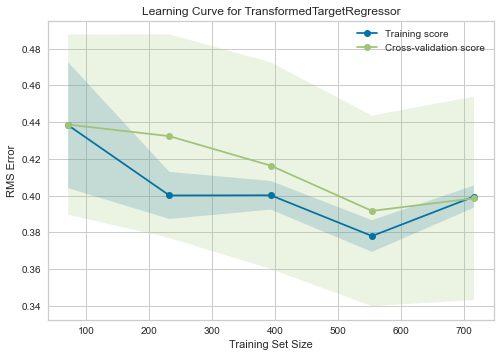

In [10]:

train_mean=-np.mean(train_score,axis=1)
train_std=-np.std(train_score,axis=1)
test_mean=-np.mean(test_score,axis=1)
test_std=-np.std(test_score,axis=1)
    
plt.figure()
plt.subplots(1)
plt.plot(train_size,train_mean, 'o-', color="b",label="Training score")
plt.plot(train_size, test_mean, 'o-', color="g",label="Cross-validation score")
plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_size, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title("Learning Curve for {}".format(str(mod).split('(')[0]))
plt.xlabel("Training Set Size")
plt.ylabel("RMS Error")
plt.legend(loc="best")
plt.show()

In [11]:
X = X.to_numpy()
# X = X.as_matrix()
y = y.to_numpy()
# y = y.as_matrix()


In [12]:
y_Test=y_Test.to_numpy()
X_Test=X_Test.to_numpy()

In [13]:
kf=cv

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    HBM_Train = mod.fit(X_train, y_train)
    HBM_Test = HBM_Train.predict(X_test)
    print('Root Mean squared error: %f'
          % mean_squared_error(y_test, HBM_Test,squared=False))
    print()

ytestunk=HBM_Train.predict(X_Test)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y_Test[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

Root Mean squared error: 0.373897

Root Mean squared error: 0.276863

Root Mean squared error: 0.391705

Root Mean squared error: 0.424982

Root Mean squared error: 0.482587

Root Mean squared error: 0.349585

Root Mean squared error: 0.386162

Root Mean squared error: 0.394261

Root Mean squared error: 0.412621

Root Mean squared error: 0.461424

error COV--->0    1.676712
dtype: float64  error mean --->0    0.184396
Name: mean, dtype: float64  error std --->0    0.309179
Name: std, dtype: float64


# train score

In [14]:
ytr=HBM_Train.predict(X)
err=np.zeros(len(ytr))
for u in range (0,len(ytr)):
    err[u]=np.sqrt((y[u]-ytr[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

error COV--->0    1.829732
dtype: float64  error mean --->0    0.189984
Name: mean, dtype: float64  error std --->0    0.34762
Name: std, dtype: float64


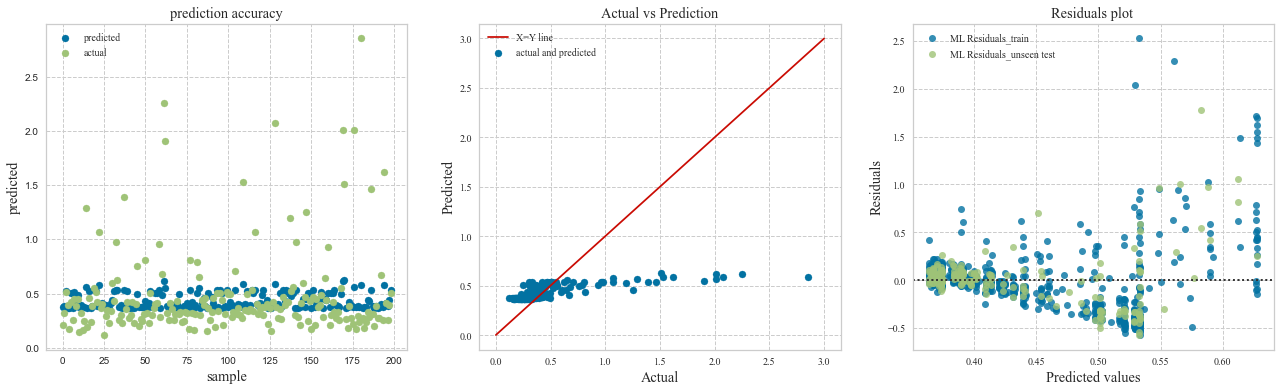

In [15]:
plt.figure(figsize=(22, 6))
csfont = {'fontname':'Times New Roman'}
plt.subplot(1,3,1)
plt.scatter(np.arange(0,len(ytestunk)),ytestunk,label='predicted')
plt.scatter(np.arange(0,len(y_Test)),y_Test,label='actual')
plt.grid( linestyle='--')
plt.title('prediction accuracy', fontsize='large',**csfont)
plt.xlabel('sample', fontsize='large',**csfont)
plt.ylabel('predicted', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.subplot(1,3,2)
plt.scatter(y_Test,ytestunk,label='actual and predicted')
plt.plot([0,3],[0,3],color='r',label='X=Y line')
plt.grid( linestyle='--')
plt.title('Actual vs Prediction', fontsize='large',**csfont)
plt.xlabel('Actual', fontsize='large',**csfont)
plt.ylabel('Predicted', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.subplot(1,3,3)
a=sns.residplot(y=abs(y), x=abs(ytr),label='ML Residuals_train')
r=sns.residplot(y=abs(y_Test), x=abs(ytestunk),label='ML Residuals_unseen test')
plt.grid( linestyle='--')
plt.title('Residuals plot ', fontsize='large',**csfont)
plt.xlabel('Predicted values', fontsize='large',**csfont)
plt.ylabel('Residuals', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.show()

---
---

# Grid search

In [251]:
param_tuning = {
        'learning_rate': [0.1,0.15,0.2],
        'max_depth': [3,4,5],
        'min_child_weight': [20.3,20.5,20.8],
    'max_delta_step':[12,13,15],
        'subsample': [0.8,0.85,0.9],
         'gamma'  : [10.5,11,11.5],
        'colsample_bytree': [0.875,0.9,0.915],
        'n_estimators' : [105,110,115]
    
 }

In [276]:
Data=pd.read_csv('140_crash.csv')
Data=Data[0:130]

Head = Data.columns[14]
Chest_deflection =  Data.columns[13]
Head_acceleration = Data.columns[15]
neck_force = Data.columns[16]

X=Data[Data.columns[0:13]]
y=Data[Chest_deflection]


In [255]:
rf = xg.XGBRegressor()
reg = GridSearchCV(rf,param_grid = param_tuning ,cv = cv, return_train_score=True,scoring="neg_root_mean_squared_error", verbose=2, n_jobs = -1)
reg.fit(X,y)
    

Fitting 10 folds for each of 6561 candidates, totalling 65610 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mono...
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.875, 0.9, 0.915],
                         'gamma': [10.5, 11, 11.5],
                         'learning_rate': [0.1, 0.15,

In [256]:
reg.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.875, gamma=11.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=15, max_depth=3,
             min_child_weight=20.3, missing=nan, monotone_constraints='()',
             n_estimators=115, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

---
---

In [277]:
# mod=GradientBoostingRegressor(subsample=0.5,n_estimators=110,min_samples_split=3,min_samples_leaf=1,max_features='auto',max_depth=25,learning_rate=0.02)#--0.64
mod=xg.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.875, gamma=11.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=15, max_depth=3,
             min_child_weight=20.3, monotone_constraints='()',
             n_estimators=115, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [278]:
cv = KFold(n_splits=10, random_state=1)

C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [279]:
y_actual = []
predict = []
X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=42)
train_size,train_score,test_score=learning_curve(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error')
kf=cv

## Learning Curve

<Figure size 576x396 with 0 Axes>

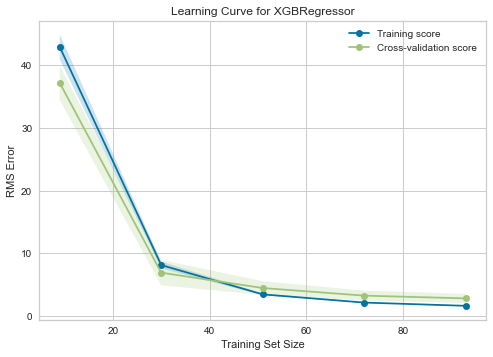

In [280]:
train_mean=-np.mean(train_score,axis=1)
train_std=-np.std(train_score,axis=1)
test_mean=-np.mean(test_score,axis=1)
test_std=-np.std(test_score,axis=1)
    
plt.figure()
plt.subplots(1)
plt.plot(train_size,train_mean, 'o-', color="b",label="Training score")
plt.plot(train_size, test_mean, 'o-', color="g",label="Cross-validation score")
plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_size, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title("Learning Curve for {}".format(str(mod).split('(')[0]))
plt.xlabel("Training Set Size")
plt.ylabel("RMS Error")
plt.legend(loc="best")
plt.show()

## Unknown data test

In [281]:
X = X.to_numpy()
y = y.to_numpy()
y_Test=y_Test.to_numpy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    HBM_Train = mod.fit(X_train, y_train)
    HBM_Test = HBM_Train.predict(X_test)
    print('Root Mean squared error: %f'
          % mean_squared_error(y_test, HBM_Test,squared=False))
    print()

ytestunk=HBM_Train.predict(X_Test)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y_Test[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

Root Mean squared error: 4.160942

Root Mean squared error: 2.814887

Root Mean squared error: 2.094712

Root Mean squared error: 3.218605

Root Mean squared error: 2.726476

Root Mean squared error: 2.455479

Root Mean squared error: 2.780050

Root Mean squared error: 4.353566

Root Mean squared error: 2.484849

Root Mean squared error: 2.054611

error COV--->0    0.821706
dtype: float64  error mean --->0    2.126364
Name: mean, dtype: float64  error std --->0    1.747247
Name: std, dtype: float64


# train score

In [282]:
ytestunk=HBM_Train.predict(X)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

error COV--->0    0.874416
dtype: float64  error mean --->0    1.325895
Name: mean, dtype: float64  error std --->0    1.159384
Name: std, dtype: float64
